In [1]:
import pandas as pd
import numpy as np
from LughaatNLP import LughaatNLP
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

dataset = pd.read_csv(r'D:\Umer Notes\7th SEM\ML\PROJECT\combined_articles.csv')
dataset = dataset[['content', 'gold_label']]
dataset = dataset.dropna()
dataset.head()

preprocessor = LughaatNLP()
def preprocess(text):
    text = preprocessor.normalize(text)
    text = preprocessor.remove_stopwords(text)
    text = preprocessor.lemmatize_sentence(text)
    tokens = preprocessor.urdu_tokenize(text)
    return tokens

dataset['content'] = dataset['content'].astype(str).apply(preprocess)
dataset.head()

documents = dataset['content']
labels = dataset['gold_label']
X_train, X_test, y_train, y_test = train_test_split(documents, labels, test_size=0.2, random_state=42)

W1209 20:44:24.363000 12220 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# -------------------------------------------------
# 1. Label encoding
# -------------------------------------------------
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Classes:", label_encoder.classes_)

# -------------------------------------------------
# 2. TF-IDF features
# -------------------------------------------------
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

X_train_text = [" ".join(doc) if isinstance(doc, list) else str(doc) for doc in X_train]
X_test_text  = [" ".join(doc) if isinstance(doc, list) else str(doc) for doc in X_test]

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()
X_test_tfidf  = tfidf_vectorizer.transform(X_test_text).toarray()

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test  TF-IDF shape:", X_test_tfidf.shape)

# -------------------------------------------------
# 3. SMOTE balancing (train only)
# -------------------------------------------------
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train_encoded)

print("Balanced train shape:", X_train_balanced.shape)
print("Balanced label dist:", np.bincount(y_train_balanced))

# -------------------------------------------------
# 4. Logistic Regression from scratch (binary)
# -------------------------------------------------
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return [1 if p > 0.5 else 0 for p in probabilities]


# -------------------------------------------------
# 5. One-vs-Rest wrapper
# -------------------------------------------------
class LogisticRegressionOVR:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.models = []

    def fit(self, X, y, n_classes):
        self.models = []
        for c in range(n_classes):
            print(f"Training classifier for class {c}")
            y_binary = np.array([1 if label == c else 0 for label in y])
            model = LogisticRegressionScratch(self.learning_rate, self.epochs)
            model.fit(X, y_binary)
            self.models.append(model)

    def predict_proba_matrix(self, X):
        # shape: (n_samples, n_classes)
        return np.vstack([m.predict_proba(X) for m in self.models]).T

    def predict(self, X):
        probs = self.predict_proba_matrix(X)
        return np.argmax(probs, axis=1)


# -------------------------------------------------
# 6. Evaluation helper: accuracy + OvR logistic loss
# -------------------------------------------------
def evaluate_lr_ovr(model, X, y):
    """
    Returns (accuracy, averaged OvR logistic loss, predictions)
    """
    probs = model.predict_proba_matrix(X)           # (n_samples, n_classes)
    y_pred = np.argmax(probs, axis=1)

    acc = accuracy_score(y, y_pred)

    # OvR-style logistic loss (binary cross-entropy per class, averaged)
    eps = 1e-15
    p = np.clip(probs, eps, 1 - eps)
    n_samples, n_classes = p.shape

    y_bin = np.eye(n_classes)[y]                   # one-hot
    loss_matrix = -(y_bin * np.log(p) + (1 - y_bin) * np.log(1 - p))
    loss = loss_matrix.mean()

    return acc, loss, y_pred

n_classes = len(np.unique(y_train_encoded))
print("Number of classes:", n_classes)

Classes: ['business' 'entertainment' 'science-technology' 'sports' 'world']
Train TF-IDF shape: (859, 10000)
Test  TF-IDF shape: (215, 10000)
Balanced train shape: (880, 10000)
Balanced label dist: [176 176 176 176 176]
Number of classes: 5



=== Tuning epochs for Logistic Regression (OvR) ===

>>> Training OVR model with epochs = 400
Training classifier for class 0
Training classifier for class 1
Training classifier for class 2
Training classifier for class 3
Training classifier for class 4
epochs=400: train_acc=0.868, val_acc=0.823, train_loss=0.528, val_loss=0.528

>>> Training OVR model with epochs = 800
Training classifier for class 0
Training classifier for class 1
Training classifier for class 2
Training classifier for class 3
Training classifier for class 4
epochs=800: train_acc=0.864, val_acc=0.828, train_loss=0.497, val_loss=0.497

>>> Training OVR model with epochs = 1200
Training classifier for class 0
Training classifier for class 1
Training classifier for class 2
Training classifier for class 3
Training classifier for class 4
epochs=1200: train_acc=0.864, val_acc=0.828, train_loss=0.486, val_loss=0.487

>>> Training OVR model with epochs = 1600
Training classifier for class 0
Training classifier for class 1
T

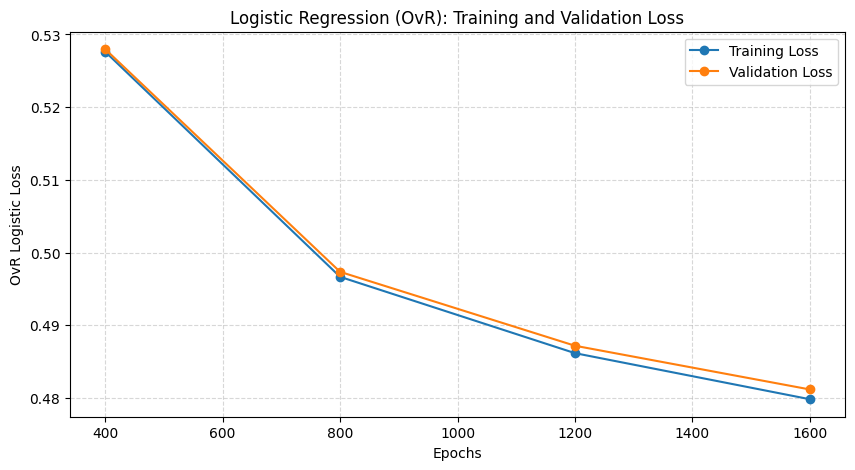

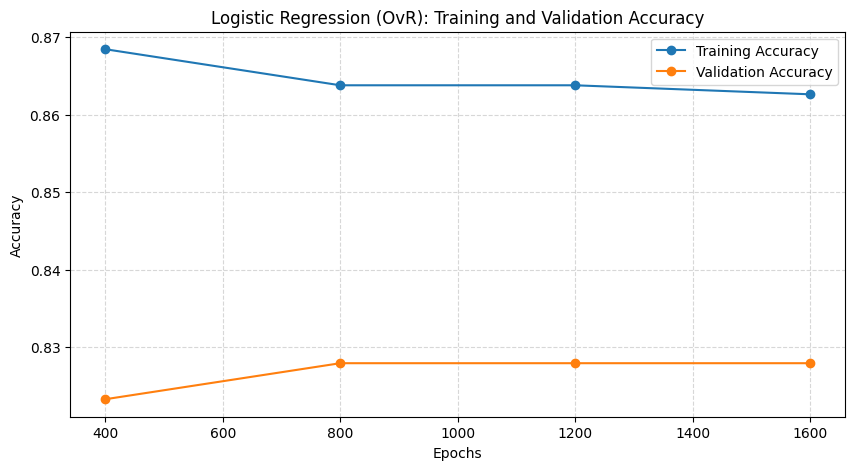


Saved model_ovr.pkl, tfidf_vectorizer.pkl, label_encoder.pkl

Final Overall Test Accuracy (epochs=800): 0.8279

Classification Report:
                    precision    recall  f1-score   support

          business       0.95      0.95      0.95        38
     entertainment       0.84      0.84      0.84        43
science-technology       0.86      0.70      0.77        46
            sports       0.79      0.86      0.83        44
             world       0.73      0.82      0.77        44

          accuracy                           0.83       215
         macro avg       0.84      0.83      0.83       215
      weighted avg       0.83      0.83      0.83       215



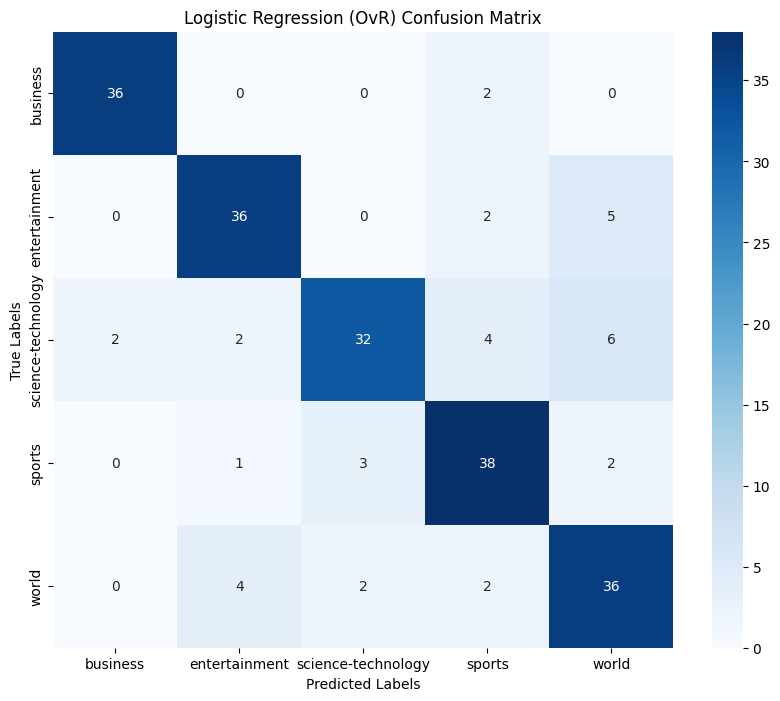


Accuracy per class:
business: 94.74%
entertainment: 83.72%
science-technology: 69.57%
sports: 86.36%
world: 81.82%


In [ ]:
epoch_list = [400, 800, 1200, 1600]

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
models_per_epoch = []

print("\n=== Tuning epochs for Logistic Regression (OvR) ===")
for E in epoch_list:
    print(f"\n>>> Training OVR model with epochs = {E}")
    model_ovr_temp = LogisticRegressionOVR(learning_rate=0.01, epochs=E)
    model_ovr_temp.fit(X_train_balanced, y_train_balanced, n_classes)

    train_acc, train_loss, _ = evaluate_lr_ovr(model_ovr_temp, X_train_tfidf, y_train_encoded)
    val_acc, val_loss, _ = evaluate_lr_ovr(model_ovr_temp, X_test_tfidf, y_test_encoded)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    models_per_epoch.append(model_ovr_temp)

    print(f"epochs={E}: train_acc={train_acc:.3f}, val_acc={val_acc:.3f}, "
          f"train_loss={train_loss:.3f}, val_loss={val_loss:.3f}")

# pick best epoch based on validation accuracy
best_idx = int(np.argmax(val_accuracies))
best_epochs = epoch_list[best_idx]
best_val_acc = val_accuracies[best_idx]
print(f"\nBest epochs = {best_epochs} | Validation Accuracy = {best_val_acc:.3f}")

# -------------------------------------------------
# 8. Plot LOSS curves (like NN & NB)
# -------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_losses, label='Training Loss')
plt.plot(epoch_list, val_losses, label='Validation Loss')
plt.title('Logistic Regression (OvR): Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('OvR Logistic Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# -------------------------------------------------
# 9. Plot ACCURACY curves
# -------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_accuracies, label='Training Accuracy')
plt.plot(epoch_list, val_accuracies, label='Validation Accuracy')
plt.title('Logistic Regression (OvR): Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# -------------------------------------------------
# 10. Use best model for final evaluation & saving
# -------------------------------------------------
model_ovr = models_per_epoch[best_idx]   # final chosen model
y_pred = model_ovr.predict(X_test_tfidf)


# -------------------------------------------------
# 11. Final metrics on test set
# -------------------------------------------------
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\nFinal Overall Test Accuracy (epochs={best_epochs}): {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

confusion_mat = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (OvR) Confusion Matrix')
plt.show()

# -------------------------------------------------
# 12. Per-class accuracy (2 decimal places)
# -------------------------------------------------
y_test_arr = np.array(y_test_encoded)
y_pred_arr = np.array(y_pred)

print("\nAccuracy per class:")
for idx, class_name in enumerate(label_encoder.classes_):
    idxs = np.where(y_test_arr == idx)[0]
    if len(idxs) == 0:
        print(f"{class_name}: no samples in test set")
        continue
    correct = np.sum(y_test_arr[idxs] == y_pred_arr[idxs])
    class_acc = correct / len(idxs)
    print(f"{class_name}: {class_acc * 100:.2f}%")

In [3]:
import joblib

joblib.dump(model_ovr, "model_ovr.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Saved model_ovr.pkl, tfidf_vectorizer.pkl, label_encoder.pkl")

Saved model_ovr.pkl, tfidf_vectorizer.pkl, label_encoder.pkl
